In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# universal sentence encoder using Transference ARCHITECTURE

In [2]:
#download the model to local so it can be used again and again
!mkdir ../sentence_wise_email/module/module_useT
# Download the module, and uncompress it to the destination folder. 
!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed" | tar -zxvC ../sentence_wise_email/module/module_useT

mkdir: cannot create directory ‘../sentence_wise_email/module/module_useT’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
./
./tfhub_module.pb
./variables/
./variables/variables.data-00000-of-00001
 99  745M   99  739M    0     0  20.1M      0  0:00:36  0:00:36 --:--:-- 22.8M./variables/variables.index
./assets/
./saved_model.pb
100  745M  100  745M    0     0  19.6M      0  0:00:37  0:00:37 --:--:-- 16.8M


In [7]:
embed = hub.Module("../sentence_wise_email/module/module_useT")

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(messages))

    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.04498474299907684, -0.05743394419550896, 0.002211471786722541, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05568016692996025, -0.009607920423150063, 0.006246279925107956, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.03874940797686577, 0.0765201598405838, -0.0007945669931359589, ...]



In [8]:
#Function so that one session can be called multiple times. 
#Useful while multiple calls need to be done for embedding. 
import tensorflow as tf
import tensorflow_hub as hub
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

embed_fn = embed_useT('../sentence_wise_email/module/module_useT')

In [9]:
messages = [
    "we are sorry for the inconvenience",
    "we are sorry for the delay",
    "we regret for your inconvenience",
    "we don't deliver to baner region in pune",
    "we will get you the best possible rate"
]

In [10]:
encoding_matrix = embed_fn(messages) 

In [15]:
np.inner(encoding_matrix, encoding_matrix)

array([[1.        , 0.87426376, 0.8004891 , 0.23807861, 0.46469775],
       [0.87426376, 1.0000001 , 0.60501504, 0.2508136 , 0.4493388 ],
       [0.8004891 , 0.60501504, 0.9999998 , 0.1784874 , 0.4195464 ],
       [0.23807861, 0.2508136 , 0.1784874 , 1.0000001 , 0.24955797],
       [0.46469775, 0.4493388 , 0.4195464 , 0.24955797, 1.0000002 ]],
      dtype=float32)

In [12]:
from math import*
from decimal import Decimal

class Similarity():
    def euclidean_distance(self,x,y):

        """ return euclidean distance between two lists """

        return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

    def manhattan_distance(self,x,y):

        """ return manhattan distance between two lists """

        return sum(abs(a-b) for a,b in zip(x,y))

    def minkowski_distance(self,x,y,p_value):

        """ return minkowski distance between two lists """

        return self.nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),
           p_value)

    def nth_root(self,value, n_root):

        """ returns the n_root of an value """

        root_value = 1/float(n_root)
        return round (Decimal(value) ** Decimal(root_value),3)

    def cosine_similarity(self,x,y):

        """ return cosine similarity between two lists """

        numerator = sum(a*b for a,b in zip(x,y))
        denominator = self.square_rooted(x)*self.square_rooted(y)
        return round(numerator/float(denominator),3)

    def square_rooted(self,x):

        """ return 3 rounded square rooted value """

        return round(sqrt(sum([a*a for a in x])),3)

In [13]:
measures = Similarity()
measures.cosine_similarity(encoding_matrix[0],encoding_matrix[2])

0.8

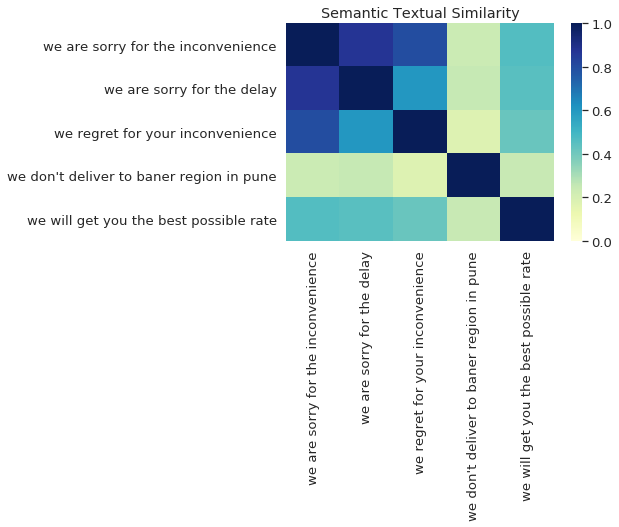

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlGnBu")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(messages, encoding_matrix, 90)

In [17]:
#It takes similarity matrix (generated from sentence encoder) as input and gives index of redundant statements
def redundant_sent_idx(sim_matrix):
    dup_idx = [] 
    for i in range(sim_matrix.shape[0]):
        if i not in dup_idx:
            tmp = [t+i+1 for t in list(np.where( sim_matrix[i][i+1:] > 0.8 )[0])]
            dup_idx.extend(tmp)
    return dup_idx

In [18]:
dup_indexes = redundant_sent_idx(np.inner(encoding_matrix,encoding_matrix))

In [19]:
dup_indexes

[1, 2]

In [20]:
unique_messages = np.delete(np.array(messages), dup_indexes)
unique_messages

array(['we are sorry for the inconvenience',
       "we don't deliver to baner region in pune",
       'we will get you the best possible rate'], dtype='<U40')

In [60]:
######

In [9]:
greet_texts = '''- - Hello
  - Hi
- - Hi
  - Hello
- - Greetings!
  - Hello
- - Hello
  - Greetings!
- - Hi, How is it going?
  - Good
- - Hi, How is it going?
  - Fine
- - Hi, How is it going?
  - Okay
- - Hi, How is it going?
  - Great
- - Hi, How is it going?
  - Could be better.
- - Hi, How is it going?
  - Not so great.
- - How are you doing?
  - Good.
- - How are you doing?
  - Very well, thanks.
- - How are you doing?
  - Fine, and you?
- - Nice to meet you.
  - Thank you.
- - How do you do?
  - I'm doing well.
- - How do you do?
  - I'm doing well. How are you?
- - Hi, nice to meet you.
  - Thank you. You too.
- - It is a pleasure to meet you.
  - Thank you. You too.
- - Top of the morning to you!
  - Thank you kindly.
- - Top of the morning to you!
  - And the rest of the day to you.
- - What's up?
  - Not much.
- - What's up?
  - Not too much.
- - What's up?
  - Not much, how about you?
- - What's up?
  - Nothing much.
- - What's up?
  - The sky's up but I'm fine thanks. What about you?
'''

In [10]:
greet_list = greet_texts.split("- -")

In [11]:
greet_list[0].strip().split('\n')[0]!=""

False

In [12]:
greets = [i.strip().split('\n')[0] for i in greet_list if i != "" ]

In [13]:
greets

['Hello',
 'Hi',
 'Greetings!',
 'Hello',
 'Hi, How is it going?',
 'Hi, How is it going?',
 'Hi, How is it going?',
 'Hi, How is it going?',
 'Hi, How is it going?',
 'Hi, How is it going?',
 'How are you doing?',
 'How are you doing?',
 'How are you doing?',
 'Nice to meet you.',
 'How do you do?',
 'How do you do?',
 'Hi, nice to meet you.',
 'It is a pleasure to meet you.',
 'Top of the morning to you!',
 'Top of the morning to you!',
 "What's up?",
 "What's up?",
 "What's up?",
 "What's up?",
 "What's up?"]

In [14]:
greets = list(set(greets))

In [15]:
greets

["What's up?",
 'It is a pleasure to meet you.',
 'How do you do?',
 'Top of the morning to you!',
 'Hi',
 'How are you doing?',
 'Hello',
 'Greetings!',
 'Hi, How is it going?',
 'Hi, nice to meet you.',
 'Nice to meet you.']

In [28]:
greet_matrix = embed_fn(greets)

In [41]:
test_text = "Hey, how are you?"
test_embed = embed_fn([test_text])

In [42]:
sim_matrix  = np.inner(test_embed, greet_matrix)
sim_matrix

array([[0.908517  , 0.5567912 , 0.9510286 , 0.4188392 , 0.5115325 ,
        0.6289985 , 0.52158314, 0.7922291 , 0.62852156, 0.5008598 ,
        0.5546435 ]], dtype=float32)

In [44]:
if sim_matrix.max() > 0.8:
    print("it is a greetings")
else:
    print("it is not a greetings")

it is a greetings
